WaveRNN
------------------------------------------

https://arxiv.org/abs/1802.08435

```
    math::
        xt = [ct-1, ft-1, ct]  # input
        ut = σ(Ru ht-1 + Iu*xt + bu)  # update gate
        rt = σ(Rr ht-1 + Ir*xt + br)  # reset gate
        et = tanh(rt∘(Re ht-1) + Ie*xt + be)  # recurrent unit
        ht = ut∘ht-1 + (1-u)∘et  # next hidden state
        yc, yf = split(ht)  # coarse, fine
        P(ct) = softmax(O2 relu(O1 yc))  # coarse distribution
        P(ft) = softmax(O4 relu(O3 yf))  # fine distribution
```

#### TODO:
- [x] create model class
- [x] create dataset class
- [x] simple training test
- [x] save & load model
- [x] generate function
- [x] simple generating test
- [x] use multiple gpu device
- [x] minibatch training
- [x] training with real voice data
- [ ] enable to use auxiliary conditions (F0, phonemes)
- [ ] train by using auxiliary conditions
- [ ] enable generate function to use conditions
- [ ] train & generate test with a single frequency sine waves
- [ ] train & generate test with different frequency sine waves
- [ ] train & generate test with human voices
- [ ] conditional sampling

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../')
import math
import numpy as np
import IPython.display as ipd
import torch
from torch.utils.data import DataLoader
from tts.WaveRNN.wavernn import WaveRNN, split_signal, combine_signal
from tts.WaveRNN.dataset import WaveRNNDataset
from tts.WaveRNN.train import train
from mlutils.utils import shape, calc_acc, plot
from sklearn.model_selection import train_test_split
from tools.libaudio.waves import sin_wave

In [2]:
sample_rate = 24000

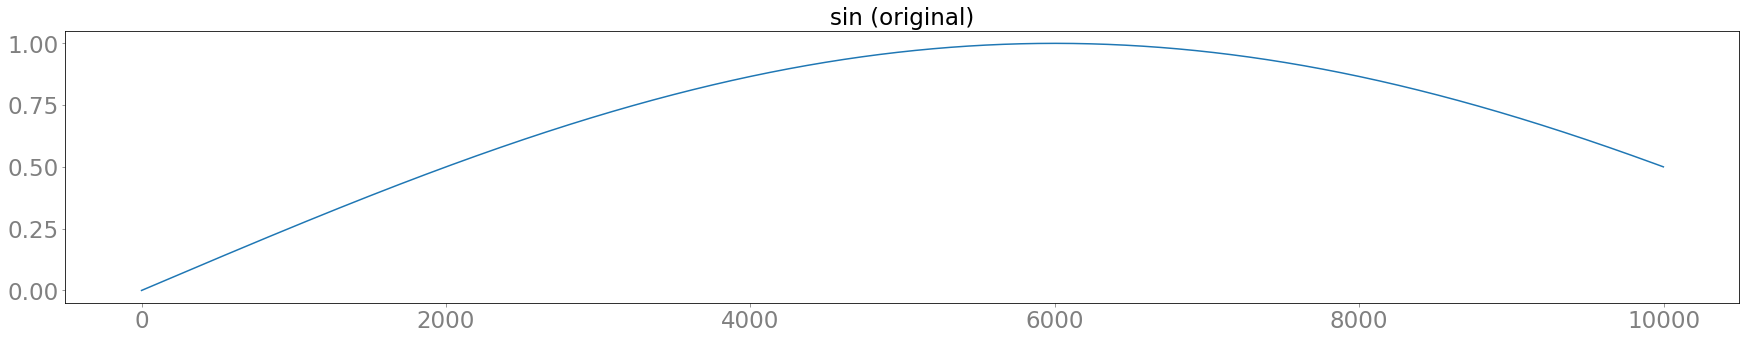

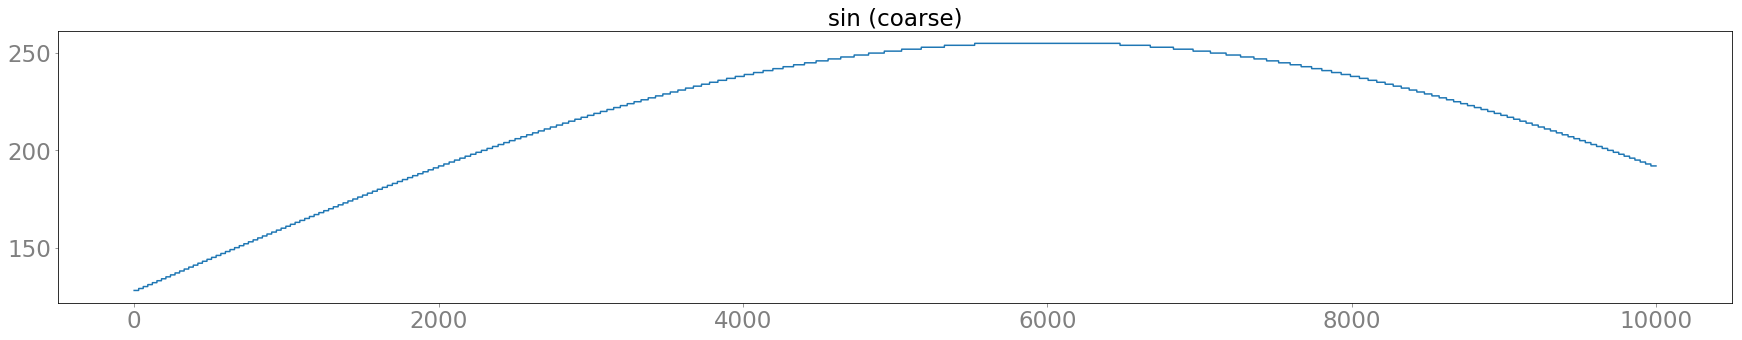

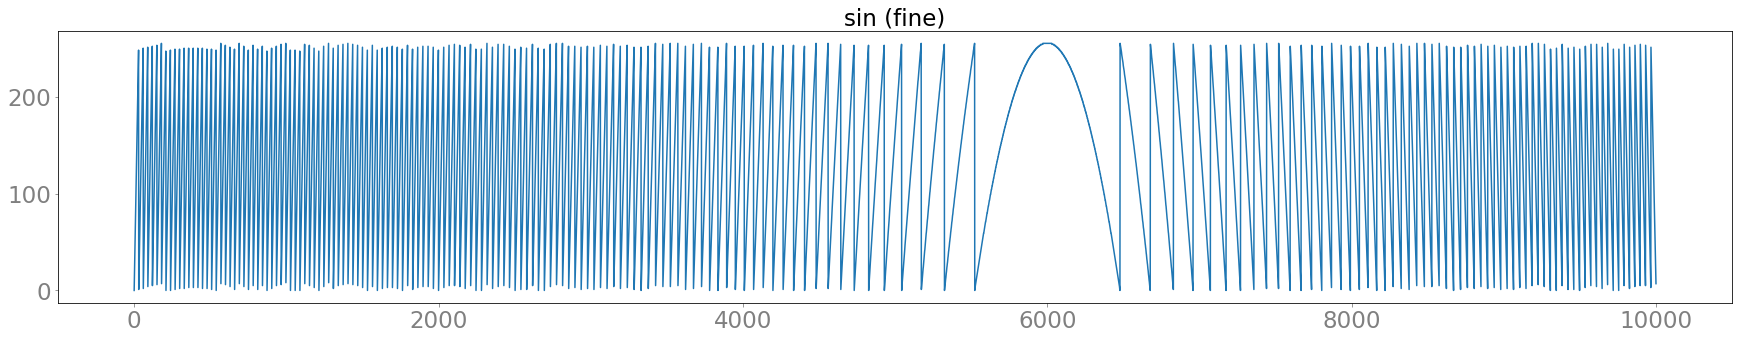

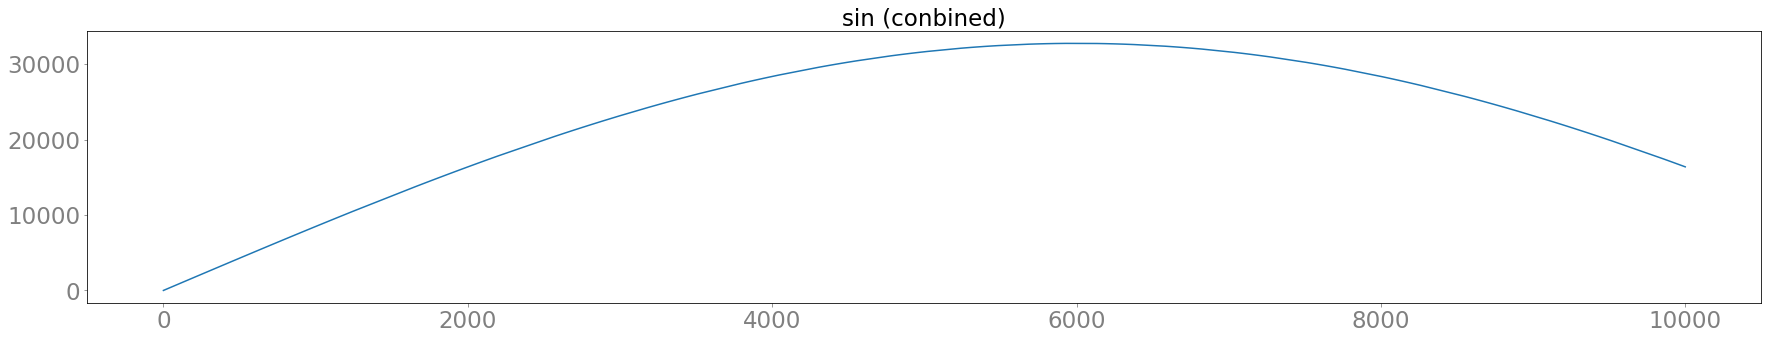

In [3]:
sin = sin_wave(freq=1, n_sample=10000, sample_rate=sample_rate)
sin_c, sin_f= split_signal(sin, 16)
sin_comb = combine_signal(sin_c, sin_f)

plot(sin, 'sin (original)')
plot(sin_c, 'sin (coarse)')
plot(sin_f, 'sin (fine)')
plot(sin_comb, 'sin (conbined)')

#### training a single frequency sin wave

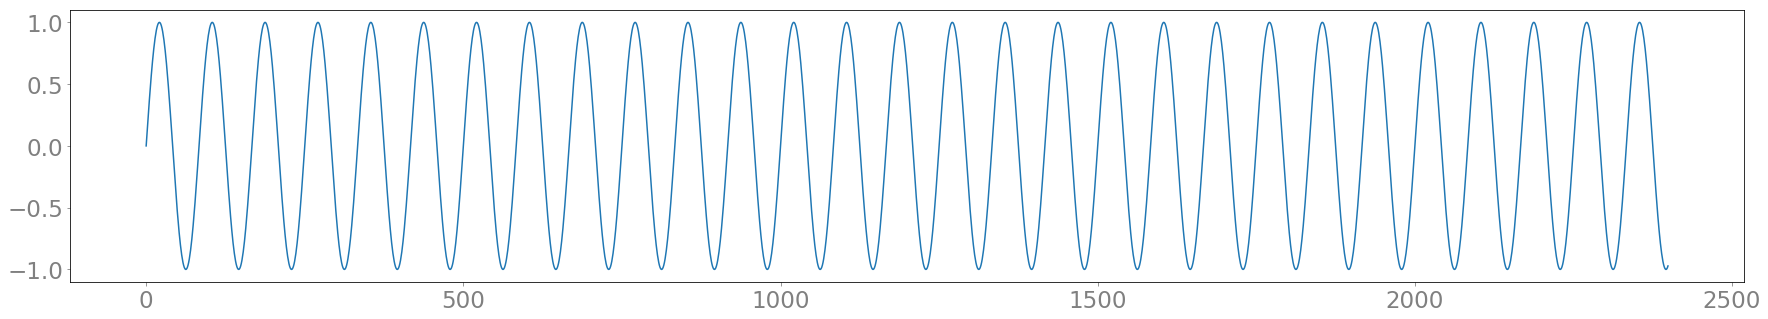

In [4]:
# test sin wave
freq = np.random.randint(100, 300)
wav = sin_wave(freq=freq, n_sample=sample_rate*0.1)
plot(wav)

In [5]:
model = WaveRNN(disable_cuda=False).cuda()
losses, loss_aves, model_1 = train(model, [wav], n_epoch=1, n_iter=500, seq_len=1000, disable_cuda=False)

Trainable Parameters: 3.050 million
epoch 0/0 index 0/0 iter: 0/500 -- loss ave: 11.1382 loss: 11.14 -- elapse: 0m 2s speed 2673.2 steps/sec
epoch 0/0 index 0/0 iter: 499/500 -- loss ave: 0.9693 loss: 0.04 -- elapse: 25m 14s speed 3029.5 steps/sec
model name:wavernn id:5c91d7bc1446821c9bb01419 saving path generated.
trying to save model parameters odict_keys(['bu', 'br', 'be', 'R.weight', 'Ic.weight', 'If.weight', 'O1.weight', 'O1.bias', 'O2.weight', 'O2.bias', 'O3.weight', 'O3.bias', 'O4.weight', 'O4.bias']) to /diskB/6/out/models/wavernn/wavernn_epoch1_n_iter500_seq_len1000_lr0.001_loss2-826_2 ..


ValueError: too many values to unpack (expected 3)

In [ ]:
plot(losses)

In [ ]:
plot(loss_aves)

training outputs

In [ ]:
train_samples = combine_signal(infer_c, infer_f)
plot(train_samples[-1000:])

#### generate test

In [ ]:
model = WaveRNN(disable_cuda=True)
model.load_model('/diskB/6/out/models/wavernn/wavernn_epoch1_n_iter500_seq_len1000_lr0.001_loss2-191_15')
model.cpu()
model.eval()

In [ ]:
coarse, fine, combined = model.generate(1000)

generated results

In [ ]:
plot(coarse[-500:])

In [ ]:
plot(fine[-500:])

In [ ]:
plot(combined[-500:])

##### train & generate a human voice

In [ ]:
dataset = WaveRNNDataset(with_conditions=False, batch_size=1)
loader = DataLoader(
    dataset, batch_size=1, shuffle=False, collate_fn=dataset.collate_fn, drop_last=False, num_workers=1)

In [ ]:
for i, d in enumerate(loader):
    if i == 5:
        wav = combine_signal(d[0].squeeze().numpy(), d[0].squeeze().numpy())
        break

ground truth

In [ ]:
plot(wav)
ipd.Audio(wav, rate=24000)

train a single utterance

In [ ]:
cuda_device = torch.device('cuda:0')

In [ ]:
model = WaveRNN(disable_cuda=False, device=cuda_device).cuda(device=cuda_device)
model.to_device(cuda_device)
dataset = WaveRNNDataset(with_conditions=False, batch_size=32)
loader = DataLoader(
    dataset, batch_size=1, collate_fn=dataset.collate_fn, drop_last=False, num_workers=1)

In [ ]:
losses, loss_aves, model_2 = train(
    model, loader, model_name='wavernn-single-voice', lr=1e-4, n_epoch=1, n_iter=48000, seq_len=1000,
    max_sampling=1, disable_cuda=False, device=cuda_device, check_inference=False)

In [ ]:
plot(losses)

In [ ]:
model_2.cpu()
model_2.eval()
model_2.to_device(cpu=True)

In [ ]:
coarse, fine, combined = model_2.generate(1000)

In [ ]:
plot(coarse[-24000:])

In [ ]:
plot(fine[-2400:])

In [ ]:
plot(combined[-24000:])

In [ ]:
ipd.Audio(combined, rate=24000)

#### train all data

In [ ]:
# full data train
losses, loss_aves, model_2, infer_c, infer_f = train(model, data_loader, n_epoch=1, n_iter=500, seq_len=1000, disable_cuda=False)